In [1]:
import openai
from openai import OpenAI
from dotenv import load_dotenv
import os
import pandas as pd
from IPython.display import Image

In [ ]:
# https://platform.openai.com/docs/assistants/overview
# https://platform.openai.com/docs/assistants/tools

In [2]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

In [3]:
# Files to upload to assistant
file1 = client.files.create(
  file=open("./data/event_data_sherdog.csv", "rb"),
  purpose='assistants'
)

file2 = client.files.create(
  file=open("./data/fighter_info.csv", "rb"),
  purpose='assistants'
)

# Create or import assistant
assistant = client.beta.assistants.create(
    name="Machine Learning Buddy Template",
    model="gpt-4o",
    instructions="""
    You are a data analyst and machine learning expert. Write and run code
    to analyze the csv files you have based on the users requests and provide
    summaries of your analysis and code blocks of how to do what you did.
    """,
    tools=[{"type": "code_interpreter"}],
    tool_resources={
        "code_interpreter": {
        "file_ids": [file1.id, file2.id]
        }
    }
)

# Create thread
thread = client.beta.threads.create()

# Add message to thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""Can you provide the recent fight performance statistics for Israel Adesanya? Then generate a 
    detailed and informative report on his performance trends and insights over his last 5 fights, and make a 
    visualization of the key findings. Provide the image file for download at the end."""
)

# Run it 
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [6]:
# Check run status 
# status='completed' when the model is done processing
# status='in_progress' model still processing
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)
run

Run(id='run_JlaqatwCzZITEWxMrvXMPvOQ', assistant_id='asst_RPLTzcoznCJjvcBwKPc5oUmp', cancelled_at=None, completed_at=1719692846, created_at=1719692810, expires_at=None, failed_at=None, incomplete_details=None, instructions='\n    You are a data analyst and machine learning expert. Write and run code\n    to analyze the csv files you have based on the users requests and provide\n    summaries of your analysis and code blocks of how to do what you did.\n    ', last_error=None, max_completion_tokens=None, max_prompt_tokens=None, metadata={}, model='gpt-4o', object='thread.run', parallel_tool_calls=True, required_action=None, response_format='auto', started_at=1719692811, status='completed', thread_id='thread_ELk0JBpdijNWvRYdXwPnWxz1', tool_choice='auto', tools=[CodeInterpreterTool(type='code_interpreter')], truncation_strategy=TruncationStrategy(type='auto', last_messages=None), usage=Usage(completion_tokens=2164, prompt_tokens=26322, total_tokens=28486), temperature=1.0, top_p=1.0, tool_

In [7]:
# Retreive and print all messages
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)
for message in reversed(messages.data):
    if hasattr(message.content[0], 'text'):
        print(message.role + ": " + message.content[0].text.value)
    elif hasattr(message.content[0], 'image_file'):
        print(message.role + ": [Image file received]")
        

# Retreive and print last message 
# messages.data[0].content[0]

# Retreive and print last message text
# messages.data[0].content[0].text.value 

user: Can you provide the recent fight performance statistics for Israel Adesanya? Then generate a 
    detailed and informative report on his performance trends and insights over his last 5 fights, and make a 
    visualization of the key findings. Provide the image file for download at the end.
assistant: Sure, let's start by examining the contents of the two uploaded CSV files to identify the relevant data for Israel Adesanya's recent fight performance statistics.
assistant: The data spans across two dataframes (`df1` and `df2`). Here is a brief overview of their contents:

1. **df1**:
   Contains information about fight events, fighters involved, and fight outcomes. Relevant columns include:
     - Event Name
     - Event Location
     - Event Date
     - Fighter 1 and Fighter 2
     - Weight Class
     - Winning Fighter
     - Winning Method
     - Winning Round
     - Winning Time

2. **df2**:
   Contains metadata about fighters. Relevant columns include:
     - Fighter
     - Ni

Image found


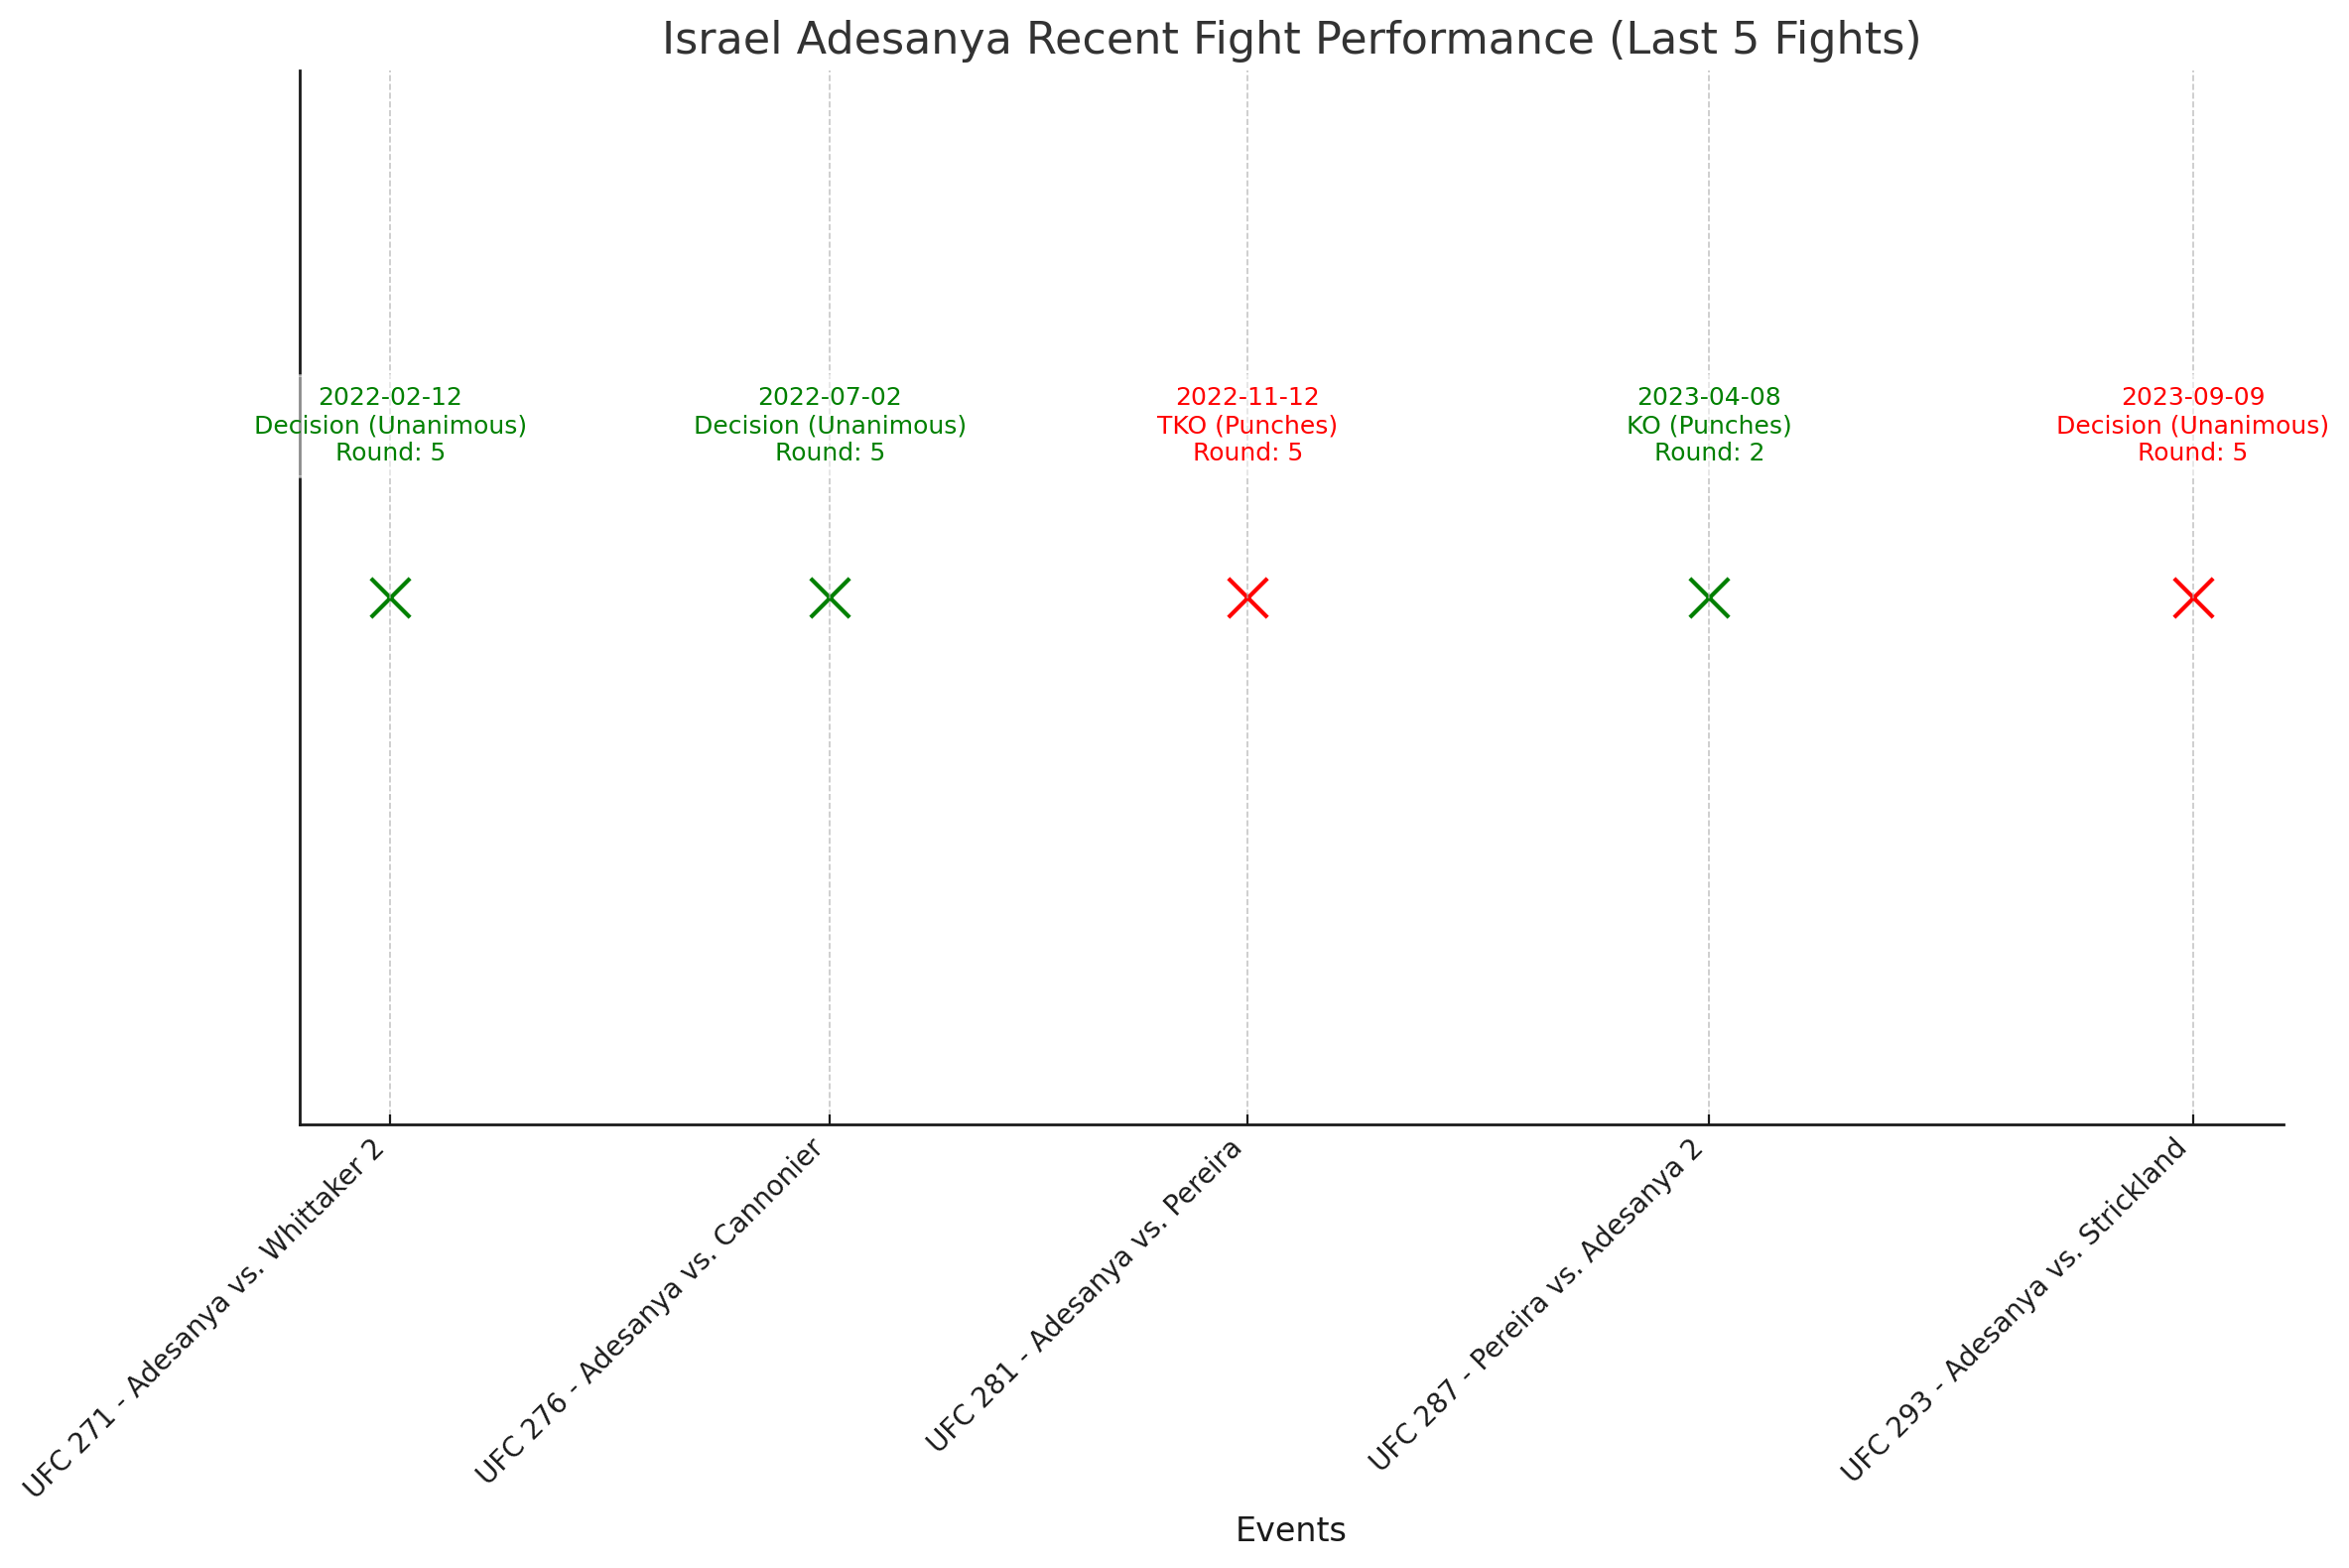

In [8]:
# Check for file images and display or for other files created
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)
file_downloaded_id = messages.data[0].content[0]

# Check for image file's file_id
if hasattr(file_downloaded_id, 'image_file'):
    print('Image found')
    image_data = client.files.content(messages.data[0].content[0].image_file.file_id)
    image_data_bytes = image_data.read()
    with open("./data/image.png", "wb") as file:
        file.write(image_data_bytes)
    display(Image(filename="./data/image.png"))    
elif hasattr(file_downloaded_id, 'text') and hasattr(file_downloaded_id.text, 'annotations'):
    print('Other file found, hmmmmm.. ')
else:
    print('No image or text file found')